In [10]:
import os
import sys
# Third party imports=
import numpy as np
import matplotlib.pyplot as plt
from weac_2.components import Layer, Config, ScenarioConfig, ModelInput, WeakLayer, Segment, CriteriaConfig
from weac_2.analysis.criteria_evaluator import CoupledCriterionResult, CriteriaEvaluator, FindMinimumForceResult
from weac_2.utils import load_dummy_profile
from weac_2.core.system_model import SystemModel
from weac_2.analysis.plotter import Plotter

from weac_2.analysis.analyzer import Analyzer

# Define test parameters
layers = [
    Layer(rho=350, h=120),
    Layer(rho=270, h=120),
    Layer(rho=180, h=120),
]
scenario_config = ScenarioConfig(
    system_type='skier',
    phi=22,
)
basic_segments = [
    Segment(length=10000, has_foundation=True, m=50),
    Segment(length=10000, has_foundation=True, m=0),
]
weak_layer = WeakLayer(
    rho=125,
    h=30,
    E=1,
)
criteria_config = CriteriaConfig(
    stress_envelope_method='adam_unpublished',
    scaling_factor=1,
    order_of_magnitude=1,
)
model_input = ModelInput(
    scenario_config=scenario_config,
    layers=layers,
    segments=basic_segments,
    weak_layer=weak_layer,
    criteria_config=criteria_config,
)

sys_model = SystemModel(
    model_input=model_input,
)

criteria_evaluator = CriteriaEvaluator(
    criteria_config=criteria_config,
)

print("weak_layer: ", weak_layer)
print("layers: ", layers)
print("scenario_config: ", scenario_config)
print("original_segments: ", basic_segments)

results_find_minimum_force: FindMinimumForceResult = criteria_evaluator.find_minimum_force(
    system=sys_model
)

print("Minimum force critical skier weight: ", results_find_minimum_force.critical_skier_weight)

min_force_segments = results_find_minimum_force.new_segments

results: CoupledCriterionResult = criteria_evaluator.evaluate_coupled_criterion(
    system=sys_model
)

cc_segments = sys_model.scenario.segments

print("Algorithm convergence:", results.converged)
print("Message:", results.message)
print("Critical skier weight:", results.critical_skier_weight)
print("Crack length:", results.crack_length)
print("Stress failure envelope:", results.max_dist_stress)
print("G delta:", results.g_delta)
print("Iterations:", results.iterations)
print("System Segments: ", sys_model.scenario.segments)

weak_layer:  rho=125.0 h=30.0 nu=0.25 E=1.0 G=0.4 kn=0.035555555555555556 kt=0.013333333333333334 G_c=1.0 G_Ic=0.56 G_IIc=0.79 E_method='bergfeld'
layers:  [Layer(rho=350.0, h=120.0, nu=0.25, E=93.83992993319691, G=37.53597197327876, tensile_strength=22.88527265054489, tensile_strength_method='sigrist', E_method='bergfeld'), Layer(rho=270.0, h=120.0, nu=0.25, E=29.95634626822852, G=11.982538507291407, tensile_strength=12.149478790828883, tensile_strength_method='sigrist', E_method='bergfeld'), Layer(rho=180.0, h=120.0, nu=0.25, E=5.03138212078731, G=2.012552848314924, tensile_strength=4.5174668584951165, tensile_strength_method='sigrist', E_method='bergfeld')]
scenario_config:  phi=22.0 system_type='skier' crack_length=0.0 collapse_factor=0.5 stiffness_ratio=1000 surface_load=0.0
original_segments:  [Segment(length=10000.0, has_foundation=True, m=50.0), Segment(length=10000.0, has_foundation=True, m=0.0)]
--- tolerance was met in find_minimum_force Call Statistics ---
- rasterize_solut

   - Generating fracture toughness envelope...


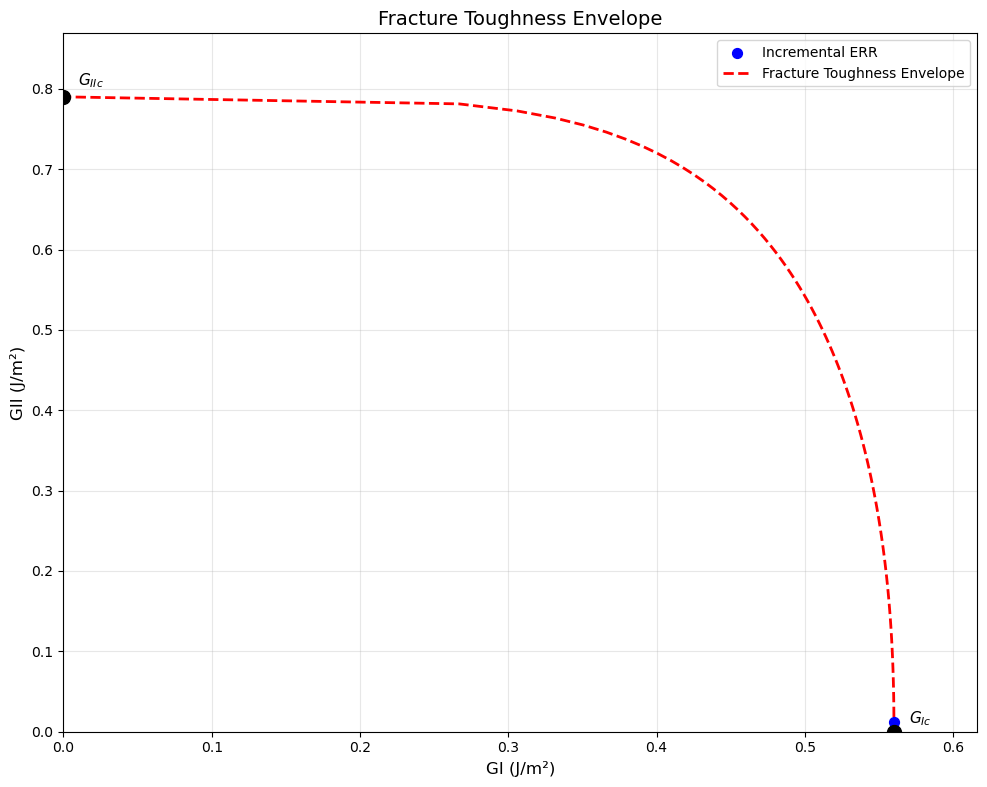

In [11]:
print("   - Generating fracture toughness envelope...")
plotter = Plotter()
fig = plotter.plot_err_envelope(
    system_model=sys_model,
    criteria_evaluator=criteria_evaluator,
    filename="err_envelope",
)

In [12]:

results = criteria_evaluator.check_crack_self_propagation(sys_model)
print("Results of crack propagation criterion: ", results)
print("System Segments: ", sys_model.scenario.segments)

# As the crack propagation criterion is not met --> investigate minimum self propagation crack boundary
initial_interval = (0, 2000)  # Interval for the crack length search (mm)

min_crack_length, min_crack_segments = criteria_evaluator.find_minimum_crack_length(sys_model, search_interval=initial_interval)
print("Segments: ", sys_model.scenario.segments)

if min_crack_length is not None:
    print(f"Minimum Crack Length for Self-Propagation: {min_crack_length} mm")
else:
    print("The search for the minimum crack length did not converge.")

Segments:  [Segment(length=9983.132215553123, has_foundation=True, m=0.0), Segment(length=16.867784446876612, has_foundation=False, m=321.6761145525312), Segment(length=6.635443256516737, has_foundation=False, m=0.0), Segment(length=9993.364556743483, has_foundation=True, m=0.0)]
Results of crack propagation criterion:  (1.1443030196974155, True)
System Segments:  [Segment(length=9983.132215553123, has_foundation=True, m=0.0), Segment(length=16.867784446876612, has_foundation=False, m=321.6761145525312), Segment(length=6.635443256516737, has_foundation=False, m=0.0), Segment(length=9993.364556743483, has_foundation=True, m=0.0)]
Interval for crack length search:  0 2000
Calculation of fracture toughness envelope:  -0.9999888381919847 14.439596397768332
Segments:  [Segment(length=9983.132215553123, has_foundation=True, m=0.0), Segment(length=16.867784446876612, has_foundation=False, m=321.6761145525312), Segment(length=6.635443256516737, has_foundation=False, m=0.0), Segment(length=9993

In [13]:
def _evaluate_system(
        system: SystemModel,
        criteria_evaluator: CriteriaEvaluator,
    ):
    analyzer = Analyzer(system)
    xsl, z, xwl = analyzer.rasterize_solution(mode="cracked", num=2000)
    fq = analyzer.sm.fq

    # Compute slab displacements on grid (cm)
    Sigmawl = np.where(np.isfinite(xwl), fq.sig(z, unit="kPa"), np.nan)
    Tauwl = np.where(np.isfinite(xwl), fq.tau(z, unit="kPa"), np.nan)
    
    min_force_sigma_kPa = fq.sig(z, unit="kPa")
    min_force_tau_kPa = fq.tau(z, unit="kPa")
    min_force_stress_envelope = criteria_evaluator.stress_envelope(min_force_sigma_kPa, min_force_tau_kPa, system.weak_layer)

    stress_envelope = criteria_evaluator.stress_envelope(
        Sigmawl, Tauwl, system.weak_layer
    )
    stress_envelope[np.isnan(stress_envelope)] = np.nanmax(stress_envelope)
    
    DERR = analyzer.differential_ERR(unit="J/m^2")
    IERR = analyzer.incremental_ERR(unit="J/m^2")
    DERR_tot = DERR[0]
    DERR_I = DERR[1]
    DERR_II = DERR[2]
    IERR_tot = IERR[0]
    IERR_I = IERR[1]
    IERR_II = IERR[2]
    
    DERR_crit = criteria_evaluator.fracture_toughness_envelope(DERR_I, DERR_II, system.weak_layer)
    IERR_crit = criteria_evaluator.fracture_toughness_envelope(IERR_I, IERR_II, system.weak_layer)
    
    return xsl, z, xwl, min_force_stress_envelope, DERR_crit, DERR_tot, DERR_I, DERR_II, IERR_crit, IERR_tot, IERR_I, IERR_II

In [14]:
import scipy.interpolate

def plot_system_evaluation(sys_model: SystemModel, criteria_evaluator: CriteriaEvaluator):

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)

    window = 3000

    xsl, z, xwl, stress_envelope, DERR_crit, DERR_tot, DERR_I, DERR_II, IERR_crit, IERR_tot, IERR_I, IERR_II = _evaluate_system(sys_model, criteria_evaluator)
    print("DERR_crit: ", DERR_crit)
    print("IERR_crit: ", IERR_crit)

    # centered window
    x_mid = (xsl[0] + xsl[-1]) / 2
    window_start = x_mid - window/2
    window_end = x_mid + window/2

    # Filter data to window
    mask = (xsl > window_start) & (xsl < window_end)
    x_orig = xsl[mask]
    stress_orig = stress_envelope[mask]

    # Create high-resolution grid (5x more points)
    x_highres = np.linspace(x_orig[0], x_orig[-1], len(x_orig) * 10)

    # Interpolate all quantities to high resolution
    stress_interp = scipy.interpolate.interp1d(x_orig, stress_orig, kind='cubic', bounds_error=False, fill_value=0.0)

    derr = np.full_like(x_highres, DERR_crit)
    ierr = np.full_like(x_highres, IERR_crit)

    # Evaluate at high resolution
    stress_highres = stress_interp(x_highres)

    # Plot critical line
    ax.hlines(1, x_highres[0], x_highres[-1], color="black", linestyle="--", alpha=0.7, label="Critical threshold")

    # Plot stress envelope
    ax.plot(x_highres, stress_highres, color="red", linewidth=2, label="Stress Envelope")

    # Plot DERR and IERR only where stress > 1
    mask_critical = stress_highres > 1
    if np.any(mask_critical):
        ax.plot(x_highres[mask_critical], derr[mask_critical], 
                color="blue", linewidth=2, label="DERR Critical")
        ax.plot(x_highres[mask_critical], ierr[mask_critical], 
                color="green", linewidth=2, label="IERR Critical")

    # Formatting
    ax.set_xlabel("Distance (mm)")
    ax.set_ylabel("Stress/Energy Release Rate")
    ax.set_title("High-Resolution Stress Analysis - Critical Region")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Set reasonable y-limits
    y_max = max(np.max(stress_highres), 
                np.max(derr[mask_critical]) if np.any(mask_critical) else 0,
                np.max(ierr[mask_critical]) if np.any(mask_critical) else 0)
    ax.set_ylim(0, y_max * 1.1)

    plt.show()

DERR_crit:  1.1443030196974155
IERR_crit:  0.9997953900982881


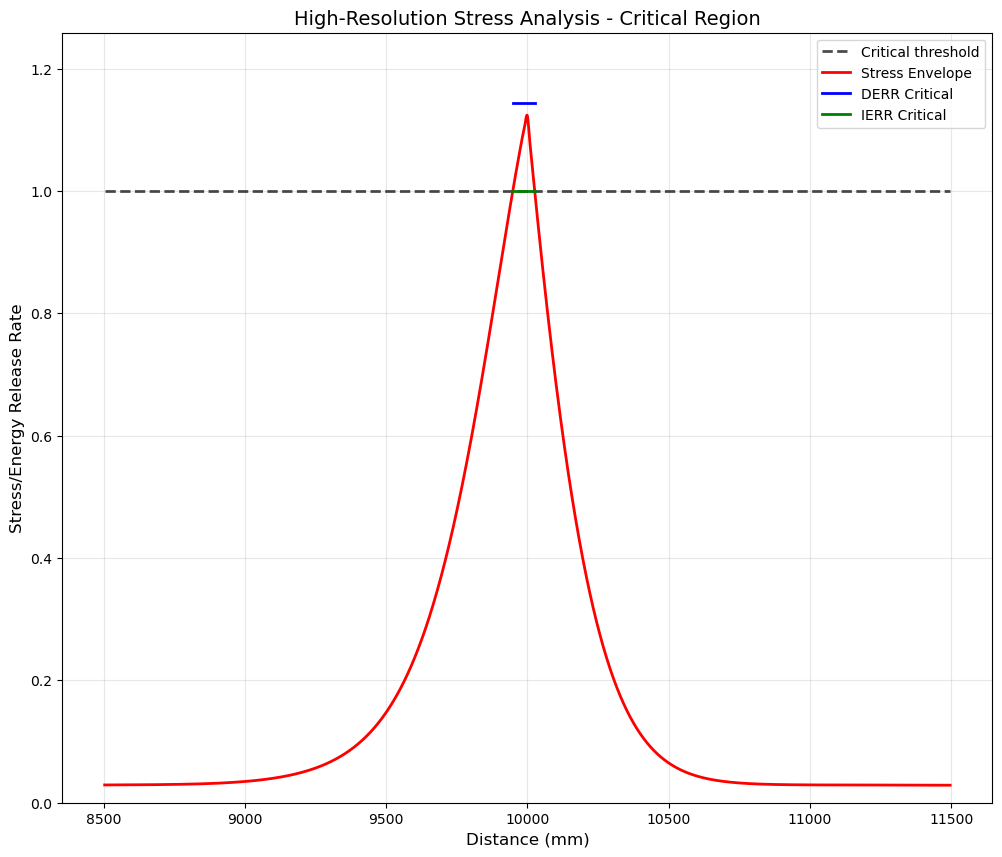

In [15]:
plot_system_evaluation(sys_model, criteria_evaluator)

Scenario [Segment(length=10000.0, has_foundation=True, m=50.0), Segment(length=10000.0, has_foundation=True, m=0.0)]


DERR_crit:  0.0
IERR_crit:  0.0


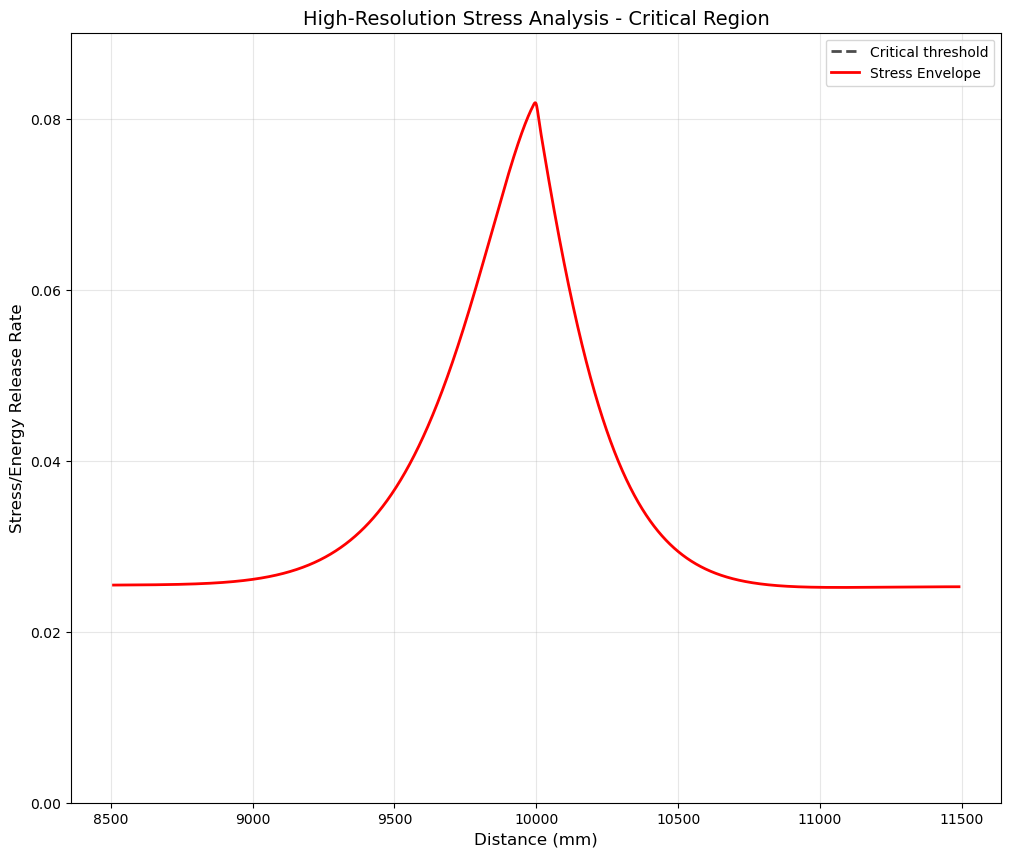

Coupled Criterion [Segment(length=9983.132215553123, has_foundation=True, m=0.0), Segment(length=16.867784446876612, has_foundation=False, m=321.6761145525312), Segment(length=6.635443256516737, has_foundation=False, m=0.0), Segment(length=9993.364556743483, has_foundation=True, m=0.0)]
DERR_crit:  1.1443030196974155
IERR_crit:  0.9997953900982881


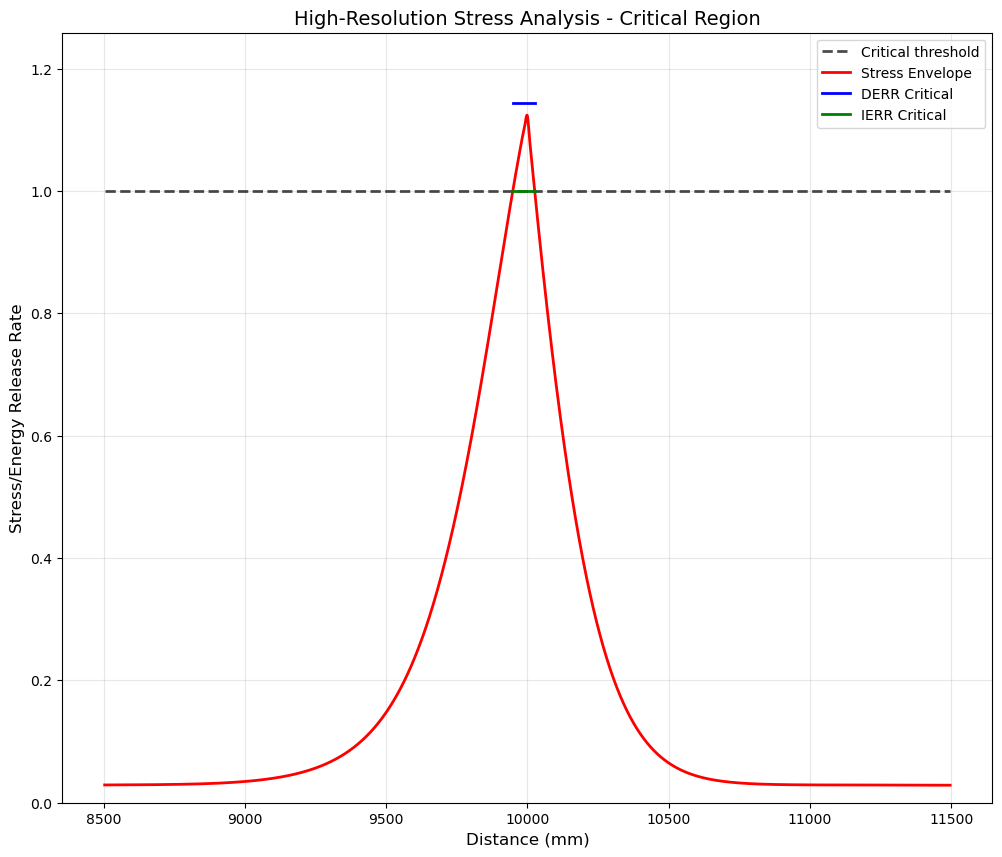

Find Minimum Force [Segment(length=10000.0, has_foundation=True, m=316.95091688522814), Segment(length=10000.0, has_foundation=True, m=0.0)]
DERR_crit:  0.0
IERR_crit:  0.0


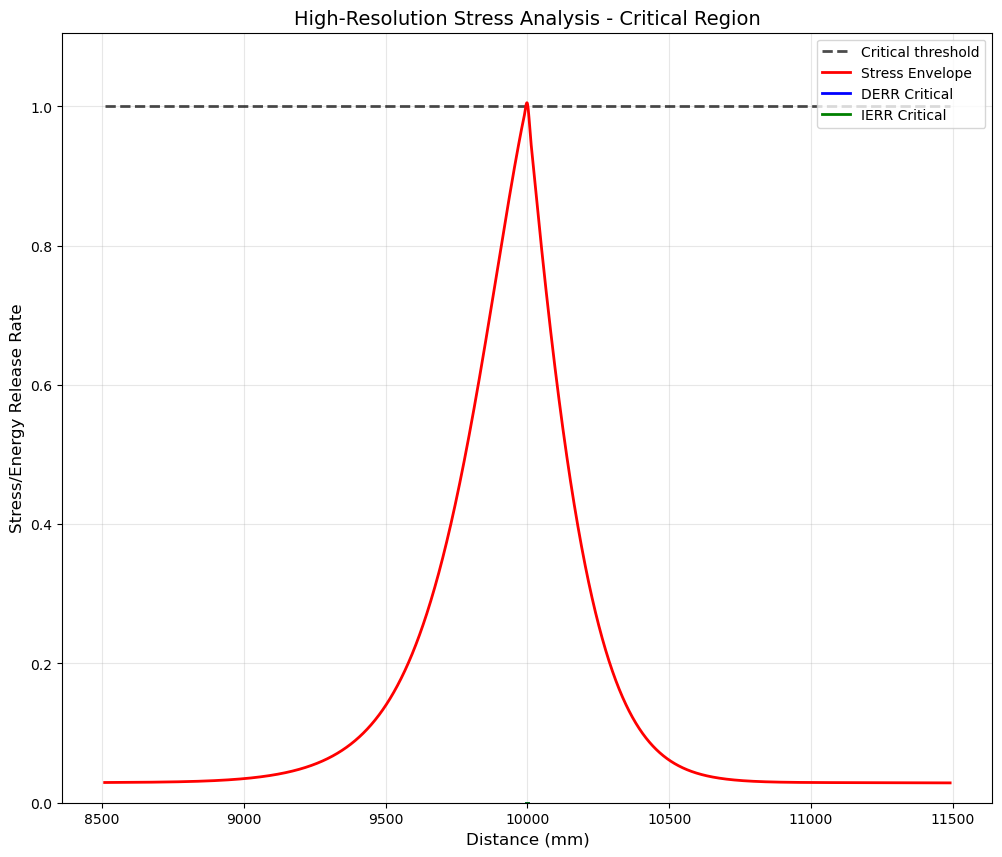

Find Minimum Crack [Segment(length=9188.194268242483, has_foundation=True, m=0.0), Segment(length=811.8057317575168, has_foundation=False, m=0.0), Segment(length=811.8057317575168, has_foundation=False, m=0.0), Segment(length=9188.194268242483, has_foundation=True, m=0.0)]
DERR_crit:  0.9999999999999851
IERR_crit:  0.00663403922775087


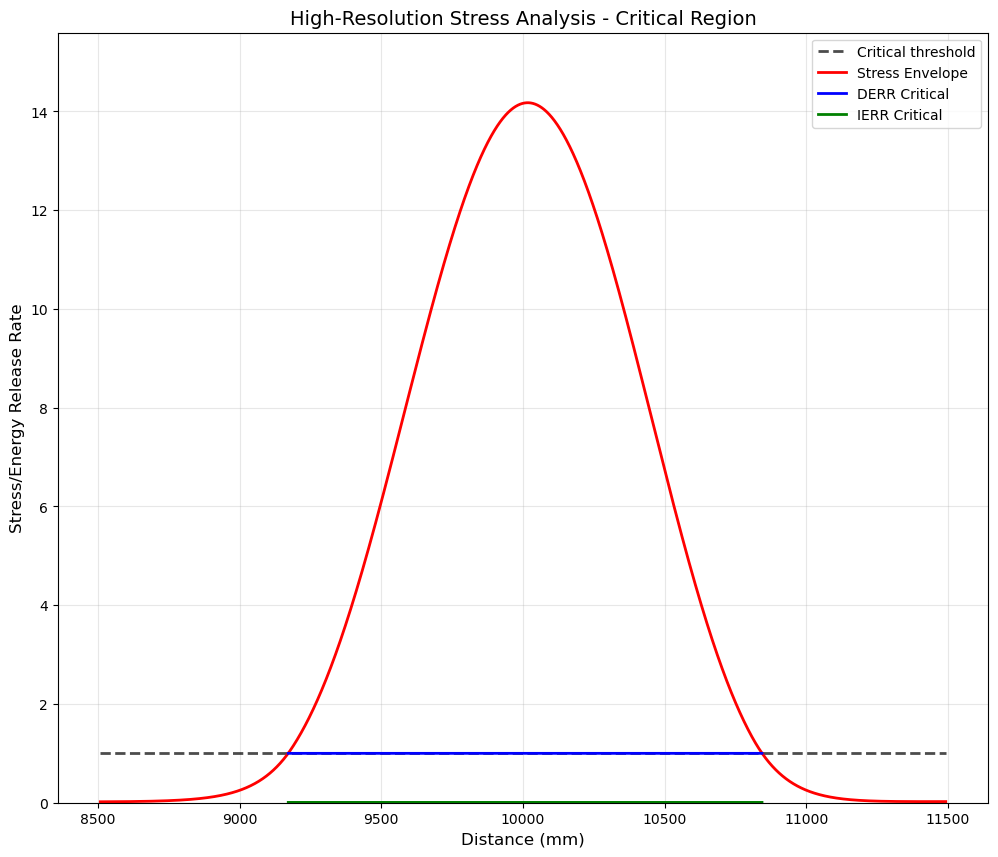

In [16]:

segments_list = [
    basic_segments,
    cc_segments,
    min_force_segments,
    min_crack_segments,
]

labels = [
    "Scenario",
    "Coupled Criterion",
    "Find Minimum Force",
    "Find Minimum Crack",
]

for i, segments in enumerate(segments_list):
    sys_model.update_scenario(segments=segments)
    print(labels[i], segments)
    plot_system_evaluation(sys_model, criteria_evaluator)
    

In [17]:
from IPython.display import clear_output, display
from ipywidgets import interactive, widgets
print("\\n=== METHOD 4: Multi-parameter interactive widget ===")

def update_system_multi_params(weight, window_size, resolution_factor):
    """Multi-parameter interactive function"""
    try:
        new_crack_length, new_segments = (
            criteria_evaluator.find_crack_length_for_weight(
                sys_model, weight
            )
        )
        sys_model.update_scenario(segments=new_segments)
        
        # Clear previous output
        clear_output(wait=True)
        
        # Modified plot function with adjustable parameters
        plot_system_evaluation_with_params(sys_model, criteria_evaluator, window_size, resolution_factor)
        
    except Exception as e:
        clear_output(wait=True)
        print(f"Error: {e}")

def plot_system_evaluation_with_params(sys_model, criteria_evaluator, window_size, resolution_factor):
    """Modified plot function with adjustable parameters"""
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    xsl, z, xwl, stress_envelope, DERR_crit, DERR_tot, DERR_I, DERR_II, IERR_crit, IERR_tot, IERR_I, IERR_II = _evaluate_system(sys_model, criteria_evaluator)

    # Use adjustable window size
    x_mid = (xsl[0] + xsl[-1]) / 2
    window_start = x_mid - window_size/2
    window_end = x_mid + window_size/2

    # Filter data to window
    mask = (xsl > window_start) & (xsl < window_end)
    x_orig = xsl[mask]
    xwl_orig = xwl[mask]
    stress_orig = stress_envelope[mask]

    derr = np.full_like(x_orig, DERR_crit)
    ierr = np.full_like(x_orig, IERR_crit)

    # Plot
    ax.hlines(1, x_orig[0], x_orig[-1], color="black", linestyle="--", alpha=0.7, label="Critical threshold")
        
    # Plot where xwl is finite
    ax.plot(xwl_orig, stress_orig, color="red", linewidth=2, label="Stress Envelope")
    
    mask_critical = stress_orig > 1
    if np.any(mask_critical):
        ax.plot(x_orig[mask_critical], derr[mask_critical], 
                    color="blue", linewidth=2, label="DERR Critical")
        ax.plot(x_orig[mask_critical], ierr[mask_critical], 
                    color="green", linewidth=2, label="IERR Critical")

    # Formatting
    ax.set_xlabel("Distance (mm)")
    ax.set_ylabel("Stress/Energy Release Rate")
    ax.set_title(f"Interactive Stress Analysis (Window: {window_size}mm, Resolution: {resolution_factor}x)")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Set reasonable y-limits
    if np.any(mask_critical):
        y_max = max(np.max(stress_orig), np.max(derr[mask_critical]), np.max(ierr[mask_critical]))
    else:
        y_max = np.max(stress_orig)
    ax.set_ylim(0, y_max * 1.1)

    plt.show()

# Create multi-parameter interactive widget
multi_widget = interactive(
    update_system_multi_params,
    weight=widgets.IntSlider(
        value=100,
        min=0,
        max=1000,
        step=10,
        description='Skier weight:',
        continuous_update=False
    ),
    window_size=widgets.IntSlider(
        value=3000,
        min=1000,
        max=10000,
        step=500,
        description='Window size:',
        continuous_update=False
    ),
    resolution_factor=widgets.IntSlider(
        value=10,
        min=1,
        max=20,
        step=1,
        description='Resolution:',
        continuous_update=False
    )
)

display(multi_widget)


\n=== METHOD 4: Multi-parameter interactive widget ===


interactive(children=(IntSlider(value=100, continuous_update=False, description='Skier weight:', max=1000, ste…

In [ ]:
def update_segments_interactive(phi,weight,crack_mid_point, crack_length, window_size, resolution_factor):
    new_segments = update_segments(basic_segments, crack_mid_point, crack_length)
    
    for seg in new_segments:
        if seg.m != 0:
            seg.m = weight
    scenario_config = sys_model.scenario.scenario_config
    scenario_config.phi = phi
    sys_model.update_scenario(new_segments, scenario_config)
    

    # Clear previous output
    clear_output(wait=True)

    # Modified plot function with adjustable parameters
    plot_system_evaluation_with_params(sys_model, criteria_evaluator, window_size, resolution_factor)


def update_segments(segments, crack_mid_point, crack_length):
    new_segments = []
    covered_length = 0
    for segment in segments:
        start_point = covered_length
        end_point = covered_length + segment.length
        print(segment.length, covered_length)
        # segment to the left of the crack
        if end_point < crack_mid_point - crack_length/2:
            print("segment to the left of the crack", covered_length)
            new_segments.append(segment)
            covered_length += segment.length
        # segment to the right of the crack
        elif start_point > crack_mid_point + crack_length/2:
            print("segment to the right of the crack", covered_length)
            new_segments.append(segment)
            covered_length += segment.length
        # crack in the middle of the segment
        elif start_point < crack_mid_point - crack_length/2 and end_point > crack_mid_point + crack_length/2:
            print("crack in the middle of the segment", covered_length)
            new_segments.append(Segment(length=crack_mid_point - crack_length/2 - covered_length, has_foundation=segment.has_foundation, m=0))
            new_segments.append(Segment(length=crack_length, has_foundation=False, m=0))
            new_segments.append(Segment(length=segment.length - (crack_mid_point + crack_length/2 - covered_length), has_foundation=segment.has_foundation, m=segment.m))
            covered_length += segment.length
        # crack touches the right side of the segment
        elif end_point < crack_mid_point + crack_length/2:
            print("crack touches the right side of the segment", covered_length)
            new_segments.append(Segment(length=crack_mid_point - crack_length/2 - covered_length, has_foundation=segment.has_foundation, m=0))
            new_segments.append(Segment(length=segment.length - (crack_mid_point - crack_length/2 - covered_length), has_foundation=False, m=segment.m))
            covered_length += segment.length
        # crack touches the left side of the segment
        elif start_point < crack_mid_point + crack_length / 2:
            print("crack touches the left side of the segment", covered_length)
            new_segments.append(Segment(length=crack_mid_point + crack_length/2 - covered_length, has_foundation=False, m=0))
            new_segments.append(Segment(length=segment.length - (crack_mid_point + crack_length/2 - covered_length), has_foundation=segment.has_foundation, m=segment.m))
            covered_length += segment.length
    return new_segments


# Create interactive widget
interactive_widget = interactive(
    update_segments_interactive,
    phi=widgets.IntSlider(
        value=0,
        min=0,
        max=90,
        step=1,
        description='Phi:',
        continuous_update=False,
    ),
    weight=widgets.IntSlider(
        value=100,
        min=0,
        max=400,
        step=10,
        description='Skier weight:',
        continuous_update=False,
    ),
    crack_length=widgets.IntSlider(
        value=200,
        min=0,
        max=2000,
        step=50,
        description='Crack Length:',
        continuous_update=False,
        style={'description_width': 'initial'}
    ),
    crack_mid_point=widgets.IntSlider(
        value=4000,
        min=0,
        max=20000,
        step=1000,
        description='Crack Mid Point:',
        continuous_update=False,
        style={'description_width': 'initial'}
    ),
    window_size=widgets.IntSlider(
        value=20000,
        min=500,
        max=20000,
        step=500,
        description='Window size:',
        continuous_update=False
    ),
    resolution_factor=widgets.IntSlider(
        value=20,
        min=1,
        max=20,
        step=1,
        description='Resolution:',
        continuous_update=False
    )
)

display(interactive_widget)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Phi:', max=90), IntSlider(value…